In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import folium
import calendar
import scipy.stats as stats
from scipy.stats import f_oneway
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='my_application')
from folium.plugins import TimestampedGeoJson
import plotly.express as px
from datetime import datetime
import string

from folium.plugins import MarkerCluster

# Сбор данных и предварительная обработка.

В данном проекте мы используем датасет Департамента полиции Нью-Йорка с данными о стрельбе в Нью-Йорке с 2006 года. Они включают в себя данные о стрелке, жертве и некоторые временные и географические параметры. Также мы нашли таблицу с адресами госпиталей в Нью-Йорке и соединили их, что мы используем впоследствии при проверке гипотез и машинном обучении.

In [2]:
df=pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv', sep=',')
df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27312 entries, 0 to 27311
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             27312 non-null  int64  
 1   OCCUR_DATE               27312 non-null  object 
 2   OCCUR_TIME               27312 non-null  object 
 3   BORO                     27312 non-null  object 
 4   LOC_OF_OCCUR_DESC        1716 non-null   object 
 5   PRECINCT                 27312 non-null  int64  
 6   JURISDICTION_CODE        27310 non-null  float64
 7   LOC_CLASSFCTN_DESC       1716 non-null   object 
 8   LOCATION_DESC            12335 non-null  object 
 9   STATISTICAL_MURDER_FLAG  27312 non-null  bool   
 10  PERP_AGE_GROUP           17968 non-null  object 
 11  PERP_SEX                 18002 non-null  object 
 12  PERP_RACE                18002 non-null  object 
 13  VIC_AGE_GROUP            27312 non-null  object 
 14  VIC_SEX               

Большинство признаков категориальные, основными числовыми признаками являются координаты места стрельбы.

In [4]:
df.isnull().sum()

INCIDENT_KEY                   0
OCCUR_DATE                     0
OCCUR_TIME                     0
BORO                           0
LOC_OF_OCCUR_DESC          25596
PRECINCT                       0
JURISDICTION_CODE              2
LOC_CLASSFCTN_DESC         25596
LOCATION_DESC              14977
STATISTICAL_MURDER_FLAG        0
PERP_AGE_GROUP              9344
PERP_SEX                    9310
PERP_RACE                   9310
VIC_AGE_GROUP                  0
VIC_SEX                        0
VIC_RACE                       0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                      10
Longitude                     10
Lon_Lat                       10
dtype: int64

Датасет содержит большое количество пропусков. Т.к. такие признаки, как 'LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC' содержат мало информации, то удалим их. Также удалим признаки 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD' ввиду их неинформативности.

In [5]:
df = df.drop(['LOC_OF_OCCUR_DESC','LOCATION_DESC','JURISDICTION_CODE','LOC_CLASSFCTN_DESC','X_COORD_CD', 'Y_COORD_CD'], axis = 1)
df.head(5)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,105,False,NaN,NaN,NaN,18-24,M,BLACK,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,40,False,NaN,NaN,NaN,18-24,M,BLACK,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,108,True,NaN,NaN,NaN,25-44,M,WHITE,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,44,False,NaN,NaN,NaN,<18,M,WHITE HISPANIC,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,47,True,25-44,M,BLACK,45-64,M,BLACK,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)


Избавимся от пропусков в данных.

In [6]:
df.isna().sum()

INCIDENT_KEY                  0
OCCUR_DATE                    0
OCCUR_TIME                    0
BORO                          0
PRECINCT                      0
STATISTICAL_MURDER_FLAG       0
PERP_AGE_GROUP             9344
PERP_SEX                   9310
PERP_RACE                  9310
VIC_AGE_GROUP                 0
VIC_SEX                       0
VIC_RACE                      0
Latitude                     10
Longitude                    10
Lon_Lat                      10
dtype: int64

In [7]:
df['Latitude']=df['Latitude'].fillna(999) #удалим строки с пропусками в Latitude и Longitude (одни и те же строки) 
l=df[df['Latitude']==999].index
df=df.drop(labels=l,axis=0)
df = df.reset_index(drop=True)

In [8]:
df['PERP_AGE_GROUP'] = df['PERP_AGE_GROUP'].fillna(999)
lab=df[df['PERP_AGE_GROUP']==999].index
df=df.drop(labels=lab,axis=0)
lab_2=df[df['PERP_AGE_GROUP']=='(null)'].index
df=df.drop(labels=lab_2,axis=0)

In [9]:
df.isna().sum()

INCIDENT_KEY               0
OCCUR_DATE                 0
OCCUR_TIME                 0
BORO                       0
PRECINCT                   0
STATISTICAL_MURDER_FLAG    0
PERP_AGE_GROUP             0
PERP_SEX                   0
PERP_RACE                  0
VIC_AGE_GROUP              0
VIC_SEX                    0
VIC_RACE                   0
Latitude                   0
Longitude                  0
Lon_Lat                    0
dtype: int64

Посмотрим какие значения принимают следующие признаки, чтобы убедиться, что там нет других пропусков.

In [10]:
for i in ['BORO','STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']:
    print(df[i].value_counts(),sep='\t')

BROOKLYN         6377
BRONX            5242
QUEENS           2613
MANHATTAN        2472
STATEN ISLAND     619
Name: BORO, dtype: int64
False    13858
True      3465
Name: STATISTICAL_MURDER_FLAG, dtype: int64
18-24      6219
25-44      5686
UNKNOWN    3148
<18        1590
45-64       617
65+          60
940           1
224           1
1020          1
Name: PERP_AGE_GROUP, dtype: int64
M    15434
U     1465
F      424
Name: PERP_SEX, dtype: int64
BLACK                             11429
WHITE HISPANIC                     2339
UNKNOWN                            1802
BLACK HISPANIC                     1314
WHITE                               283
ASIAN / PACIFIC ISLANDER            154
AMERICAN INDIAN/ALASKAN NATIVE        2
Name: PERP_RACE, dtype: int64
25-44      7595
18-24      6336
<18        1970
45-64      1233
65+         132
UNKNOWN      56
1022          1
Name: VIC_AGE_GROUP, dtype: int64
M    15465
F     1850
U        8
Name: VIC_SEX, dtype: int64
BLACK                            

In [11]:
df = df[~df['PERP_AGE_GROUP'].isin(['1020','940','224'])] #обработаем пропуски, обозначенные числами
df=df[~df['VIC_AGE_GROUP'].isin(['1022'])]

In [12]:
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE']) #переведем признак во временной формат
df=df.sort_values(by='OCCUR_DATE', ascending=False)
df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude,Lon_Lat
26583,261190187,2022-12-31,23:41:00,QUEENS,105,False,18-24,M,BLACK,<18,M,BLACK,40.693091,-73.733598,POINT (-73.733598 40.693091)
26323,261175635,2022-12-30,16:26:00,BRONX,44,False,18-24,M,WHITE HISPANIC,45-64,M,BLACK,40.837369,-73.906691,POINT (-73.906691 40.837369)
26420,261176929,2022-12-30,17:00:00,MANHATTAN,30,False,25-44,M,BLACK,25-44,M,BLACK,40.825160,-73.949519,POINT (-73.949519 40.82516)
26192,261120108,2022-12-29,16:48:00,BRONX,42,True,18-24,F,BLACK,25-44,M,BLACK,40.830025,-73.908341,POINT (-73.908341 40.830025)
25856,261120017,2022-12-29,22:08:00,QUEENS,101,False,18-24,M,BLACK,25-44,F,BLACK,40.603766,-73.759286,POINT (-73.759286 40.603766)


У нас есть таблица с адресами больниц в Нью-Йорке, достанем оттуда их координаты.

In [13]:
hospitals=pd.read_csv('Hospitals.csv', sep=',')
hospitals['Location 1']

0     413 120th Street\nNew York, NY 10035\n(40.7982...
1     79 01\nElmhurst, NY 11373\n(40.738710402563, -...
2     2201 Neptune Avenue\nBrooklyn, NY 11224\n(40.5...
3     114 02 Guy R Brewer Blvd\nJamaica, NY 11434\n(...
4     348 156th Street\nBronx, NY 10451\n(40.8213011...
                            ...                        
73    1420 Bushwick Avenue\nBrooklyn, NY 11207\n(40....
74    462 First Avenue\nNew York, NY 10016\n(40.7396...
75    769 Onderdonk Avenue\nRidgewood, NY 11385\n(40...
76    60 Madison Street\nNew York, NY 10038\n(40.711...
77    1225 Gerard Avenue\nBronx, NY 10452\n(40.83590...
Name: Location 1, Length: 78, dtype: object

In [14]:
hospitals[['A', 'B','C']] = hospitals['Location 1']. str.split('\n', 3 , expand= True )
hospitals[['x','y']] = hospitals['C']. str.split(',', 1 , expand= True )
hospitals.head(5)

,Facility Type,Borough,Facility Name,Cross Streets,Phone,Location 1,A,B,C,x,y
0,Child Health Center,Manhattan,La Clinica Del Barrio,NaN,212-410-7940,"413 120th Street\nNew York, NY 10035\n(40.7982...",413 120th Street,"New York, NY 10035","(40.798205044469, -73.932667945174)",(40.798205044469,-73.932667945174)
1,Acute Care Hospital,Queens,Elmhurst Hospital Center,NaN,718-334-4000,"79 01\nElmhurst, NY 11373\n(40.738710402563, -...",79 01,"Elmhurst, NY 11373","(40.738710402563, -73.878351155182)",(40.738710402563,-73.878351155182)
2,Child Health Center,Brooklyn,Ida G. Israel Community Health Center,W. 22nd St. & W. 23rd St.,718-946-3400,"2201 Neptune Avenue\nBrooklyn, NY 11224\n(40.5...",2201 Neptune Avenue,"Brooklyn, NY 11224","(40.578488319967, -73.989497148121)",(40.578488319967,-73.989497148121)
3,Child Health Center,Queens,South Queens Community Health Center,NaN,718-883-6699,"114 02 Guy R Brewer Blvd\nJamaica, NY 11434\n(...",114 02 Guy R Brewer Blvd,"Jamaica, NY 11434","(40.676945262114, -73.775306901692)",(40.676945262114,-73.775306901692)
4,Child Health Center,Bronx,Melrose Houses Child Health Clinic,between Morris Ave. & Courtlandt Ave.,718-292-2820,"348 156th Street\nBronx, NY 10451\n(40.8213011...",348 156th Street,"Bronx, NY 10451","(40.821301194646, -73.917709787212)",(40.821301194646,-73.917709787212)


In [15]:
hospitals['x_new'] = hospitals['x'].replace(to_replace ='[()]', value = '', regex = True)
hospitals['y_new'] = hospitals['y'].replace(to_replace ='[()]', value = '', regex = True)

In [16]:
hospitals['x_new']=hospitals['x_new'].apply(lambda x: str(x).replace(",", ".")).astype('float')
hospitals['y_new']=hospitals['y_new'].apply(lambda x: str(x).replace(",", ".")).astype('float')

In [17]:
hospitals=hospitals.drop(columns=['A','B','C','x','y'],axis=0)
hospitals.head(5)

,Facility Type,Borough,Facility Name,Cross Streets,Phone,Location 1,x_new,y_new
0,Child Health Center,Manhattan,La Clinica Del Barrio,NaN,212-410-7940,"413 120th Street\nNew York, NY 10035\n(40.7982...",40.798205,-73.932668
1,Acute Care Hospital,Queens,Elmhurst Hospital Center,NaN,718-334-4000,"79 01\nElmhurst, NY 11373\n(40.738710402563, -...",40.738710,-73.878351
2,Child Health Center,Brooklyn,Ida G. Israel Community Health Center,W. 22nd St. & W. 23rd St.,718-946-3400,"2201 Neptune Avenue\nBrooklyn, NY 11224\n(40.5...",40.578488,-73.989497
3,Child Health Center,Queens,South Queens Community Health Center,NaN,718-883-6699,"114 02 Guy R Brewer Blvd\nJamaica, NY 11434\n(...",40.676945,-73.775307
4,Child Health Center,Bronx,Melrose Houses Child Health Clinic,between Morris Ave. & Courtlandt Ave.,718-292-2820,"348 156th Street\nBronx, NY 10451\n(40.8213011...",40.821301,-73.917710


Рассчитаем Евклидово расстояние между местом преступления и адресом ближайшего к нему госпиталя в Нью-Йорке и добавим этот признок в таблицу с шутингом.

In [18]:
def euclidean(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

In [19]:
distance_best=[]
hospital=[]
for i in range (df['Longitude'].size):
    distance=[]
    for j in range (hospitals['x_new'].size):
        dist=euclidean(df['Latitude'].iloc[i], df['Longitude'].iloc[i], hospitals['x_new'].iloc[j], hospitals['y_new'].iloc[j])
        distance.append(dist)
    distance_best.append(np.min(distance))
    hospital.append(hospitals['Facility Name'])

In [20]:
df['distance']=distance_best #столбец ближайших расстояний к месту стрельбы

Закодируем категориальный признак – факт смерти жертвы (умер - 1, остался жив - 0).

In [21]:
df['STATISTICAL_MURDER_FLAG']=np.where(df['STATISTICAL_MURDER_FLAG']==True,1,0)
df.head(5)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude,Lon_Lat,distance
26583,261190187,2022-12-31,23:41:00,QUEENS,105,0,18-24,M,BLACK,<18,M,BLACK,40.693091,-73.733598,POINT (-73.733598 40.693091),0.029070
26323,261175635,2022-12-30,16:26:00,BRONX,44,0,18-24,M,WHITE HISPANIC,45-64,M,BLACK,40.837369,-73.906691,POINT (-73.906691 40.837369),0.005830
26420,261176929,2022-12-30,17:00:00,MANHATTAN,30,0,25-44,M,BLACK,25-44,M,BLACK,40.825160,-73.949519,POINT (-73.949519 40.82516),0.007743
26192,261120108,2022-12-29,16:48:00,BRONX,42,1,18-24,F,BLACK,25-44,M,BLACK,40.830025,-73.908341,POINT (-73.908341 40.830025),0.002551
25856,261120017,2022-12-29,22:08:00,QUEENS,101,0,18-24,M,BLACK,25-44,F,BLACK,40.603766,-73.759286,POINT (-73.759286 40.603766),0.066480


In [22]:
df.to_csv('df1.csv', sep=',', index=False) #сохранение итоговой таблицы в файл df1.csv

# EDA и визуализация. 

## Посмотрим на признаки шутера с помощью визуализаций

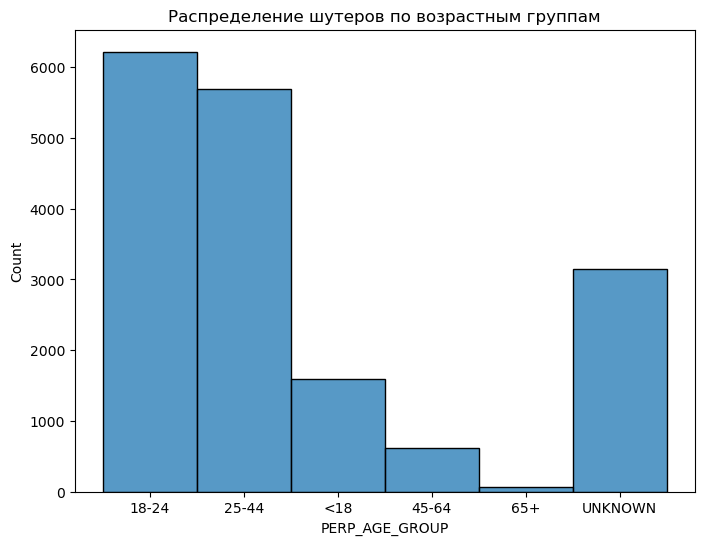

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='PERP_AGE_GROUP')
plt.title('Распределение шутеров по возрастным группам');

**Вывод:** наибольшее количество шутеров относится к возрастной группе от 18 до 44 лет, наименьшее - к группе 65+. 

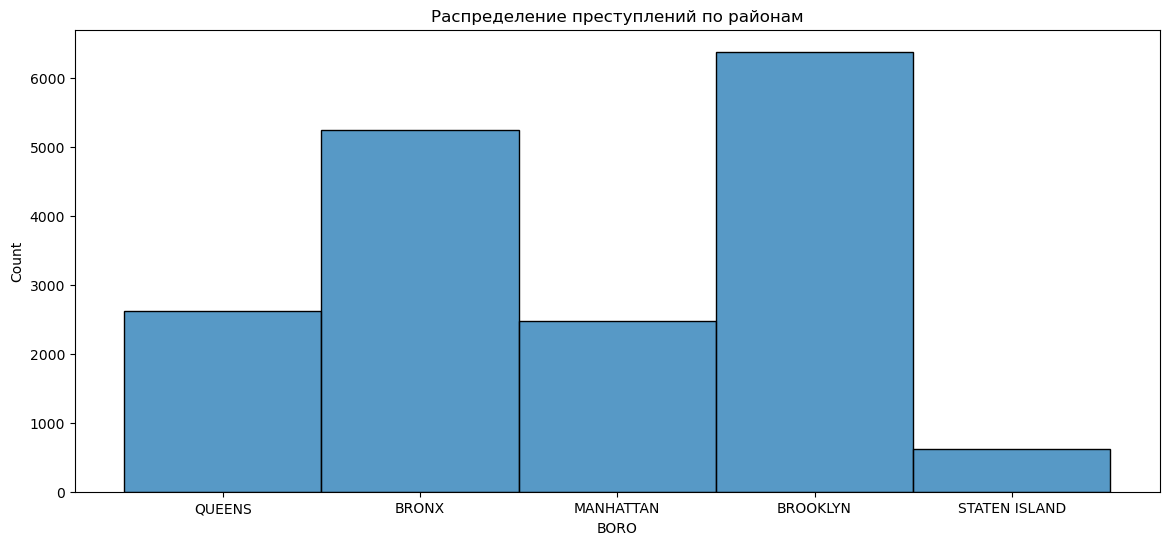

In [24]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='BORO')
plt.title('Распределение преступлений по районам');

**Вывод**: наибольшее количество шуттингов было совершенно в Бруклине и Бронксе, наименьшее - Статен-Айленд (наиболее территориально удалённый и наименее населённый из всех административных округов Нью-Йорка).

Мы составили интерактивную карту инцедентов стрельбы, которая приложена отдельным файлом под названием map_NYPD.html, мы убрали её вывод, так как файл с ним получался слишком тяжелым.

In [25]:
m = folium.Map(location=[40.7142700, 43.0166700], zoom_start=4)
for index, row in df.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    borough = row['BORO']
    killed = row['STATISTICAL_MURDER_FLAG']
    
    if killed == 0:
        color = 'green'
    else:
        color='red'
    
    
    radius = 1 * 5
    
    popup = folium.Popup('Borough {}, Killed: {}'.format(borough, killed), parse_html=True)
        
    folium.CircleMarker(location=[lat, lon], radius=radius, color=color, fill=True, fill_color=color, popup=popup).add_to(m)


In [26]:
m.save("map_NYPD.html")

In [27]:
df['PERP_SEX'].value_counts() #распределение полов шутеров

M    15430
U     1465
F      424
Name: PERP_SEX, dtype: int64

In [28]:
df['PERP_RACE'].value_counts().apply(lambda x:x/df['PERP_RACE'].count()) #распределение долей шутеров по расам 

BLACK                             0.659796
WHITE HISPANIC                    0.134939
UNKNOWN                           0.104048
BLACK HISPANIC                    0.075870
WHITE                             0.016340
ASIAN / PACIFIC ISLANDER          0.008892
AMERICAN INDIAN/ALASKAN NATIVE    0.000115
Name: PERP_RACE, dtype: float64

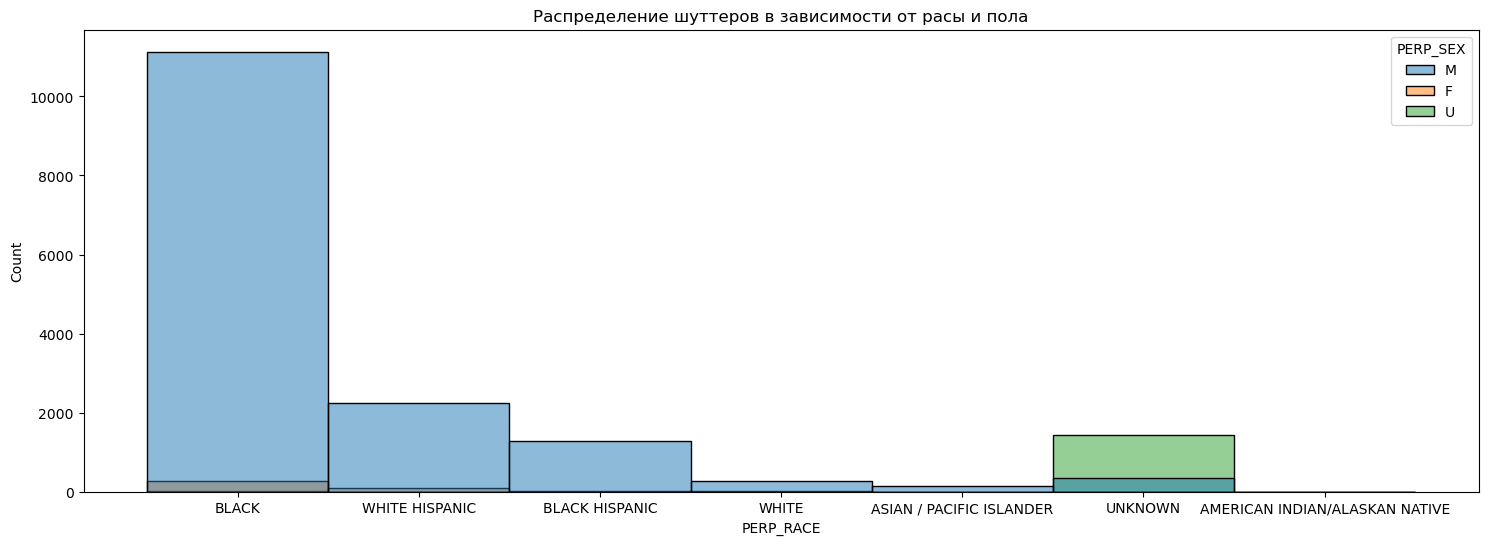

In [29]:
plt.figure(figsize=(18, 6))
sns.histplot(data=df, x='PERP_RACE', hue='PERP_SEX')
plt.title('Распределение шуттеров в зависимости от расы и пола');

**Вывод:** наибольшее количество шутеров - темнокожие мужчины. Женщины занимают крайне незначительную долю от общего числа шутеров. По этнической принадлежности среди шутеров меньше всего американских индейцев и жителей аляски. 

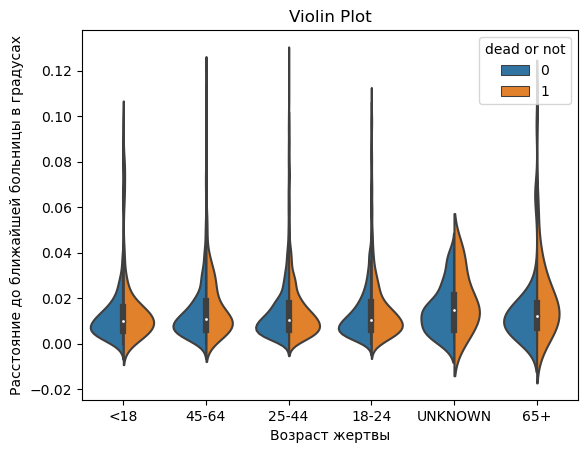

In [30]:
df2 = pd.DataFrame({'Distance': df['distance'], 'dead or not': df['STATISTICAL_MURDER_FLAG'], 'age':df['VIC_AGE_GROUP']})

sns.violinplot(x='age',y='Distance',hue='dead or not', data=df2, split=True)

plt.xlabel('Возраст жертвы')
plt.ylabel('Расстояние до ближайшей больницы в градусах')
plt.title('Violin Plot')

plt.show()

**Вывод:** в возрастных группах 45-64 и 65+, а также в группе с неизвестным возрастом по графику видно большее количество случаев выживания жертвы после стрельбы, чем смертельного исхода при _близком расстоянии_ до больницы (0-0.02 градусов). При _большем расстоянии_ до ближайшей больницы в этих группах по графику видно, что жертва в большинстве случаев умирает. В остальных возрастных группах исходы стрельбы распределены равномерно в обе стороны.  

Создадим таблицу с категориальными признаками, закодированными с помощью OHE, а также с расстоянием до ближайшей больницы.

In [31]:
d=pd.DataFrame(data=df, columns={'BORO','VIC_AGE_GROUP','VIC_SEX','VIC_RACE', 'STATISTICAL_MURDER_FLAG', 'distance', 
                                   'PERP_AGE_GROUP', 
                                   'PERP_SEX', 'PERP_RACE' })
d = pd.get_dummies(d, columns=['BORO','VIC_AGE_GROUP','VIC_SEX','VIC_RACE',
                               'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE' ], 
                   drop_first=True)
d.head()

,distance,STATISTICAL_MURDER_FLAG,BORO_BROOKLYN,BORO_MANHATTAN,BORO_QUEENS,BORO_STATEN ISLAND,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,...,PERP_AGE_GROUP_<18,PERP_AGE_GROUP_UNKNOWN,PERP_SEX_M,PERP_SEX_U,PERP_RACE_ASIAN / PACIFIC ISLANDER,PERP_RACE_BLACK,PERP_RACE_BLACK HISPANIC,PERP_RACE_UNKNOWN,PERP_RACE_WHITE,PERP_RACE_WHITE HISPANIC
26583,0.029070,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
26323,0.005830,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
26420,0.007743,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
26192,0.002551,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
25856,0.066480,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [32]:
d.corr() #построим корреляционную матрицу по этим признакам и расстоянию

,distance,STATISTICAL_MURDER_FLAG,BORO_BROOKLYN,BORO_MANHATTAN,BORO_QUEENS,BORO_STATEN ISLAND,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,...,PERP_AGE_GROUP_<18,PERP_AGE_GROUP_UNKNOWN,PERP_SEX_M,PERP_SEX_U,PERP_RACE_ASIAN / PACIFIC ISLANDER,PERP_RACE_BLACK,PERP_RACE_BLACK HISPANIC,PERP_RACE_UNKNOWN,PERP_RACE_WHITE,PERP_RACE_WHITE HISPANIC
distance,1.000000,0.009666,-0.167504,-0.190705,0.433607,0.082632,-0.001137,0.006788,0.009872,-0.014903,...,-0.011731,-0.027307,0.005951,-0.009790,0.045724,-0.016822,-0.031304,-0.010940,0.102180,0.006788
STATISTICAL_MURDER_FLAG,0.009666,1.000000,-0.025928,-0.009232,-0.001121,0.007119,0.049122,0.033853,0.025874,-0.053248,...,-0.015550,-0.194918,0.080994,-0.104825,0.026428,0.028273,-0.001576,-0.121737,0.060770,0.041162
BORO_BROOKLYN,-0.167504,-0.025928,1.000000,-0.311393,-0.321757,-0.146958,-0.005397,0.007016,0.000556,0.003674,...,0.001924,0.062105,-0.032860,0.044166,-0.022566,0.153165,-0.099806,0.037482,-0.020951,-0.154306
BORO_MANHATTAN,-0.190705,-0.009232,-0.311393,1.000000,-0.171959,-0.078540,0.020849,0.005188,-0.003480,-0.003677,...,0.013233,-0.022750,0.001861,-0.014251,-0.021054,-0.030788,0.052700,-0.020602,-0.009607,0.029750
BORO_QUEENS,0.433607,-0.001121,-0.321757,-0.171959,1.000000,-0.081154,0.012487,-0.006919,-0.001698,-0.030090,...,-0.035694,0.010059,-0.005174,0.000561,0.073488,-0.000016,-0.049499,0.002707,0.030923,0.003969
BORO_STATEN ISLAND,0.082632,0.007119,-0.146958,-0.078540,-0.081154,1.000000,-0.007761,0.013222,0.008162,-0.005300,...,0.000185,-0.054449,0.027453,-0.029464,0.001643,0.030583,-0.032847,-0.037086,0.100302,-0.021418
VIC_AGE_GROUP_25-44,-0.001137,0.049122,-0.005397,0.020849,0.012487,-0.007761,1.000000,-0.244623,-0.077433,-0.316543,...,-0.121337,-0.053754,0.025076,-0.041101,0.019192,0.019446,-0.007947,-0.036982,0.012783,0.002184
VIC_AGE_GROUP_45-64,0.006788,0.033853,0.007016,0.005188,-0.006919,0.013222,-0.244623,1.000000,-0.024263,-0.099186,...,-0.028148,-0.044318,0.023399,-0.039780,0.007262,0.003067,0.000383,-0.038456,0.068811,0.001722
VIC_AGE_GROUP_65+,0.009872,0.025874,0.000556,-0.003480,-0.001698,0.008162,-0.077433,-0.024263,1.000000,-0.031396,...,-0.004871,-0.013760,0.009365,-0.012325,-0.001229,-0.004334,0.015007,-0.014644,0.056782,-0.013237
VIC_AGE_GROUP_<18,-0.014903,-0.053248,0.003674,-0.003677,-0.030090,-0.005300,-0.316543,-0.099186,-0.031396,1.000000,...,0.190917,0.027313,-0.012327,0.029643,-0.014562,-0.008751,0.006549,0.026223,-0.028962,-0.001506


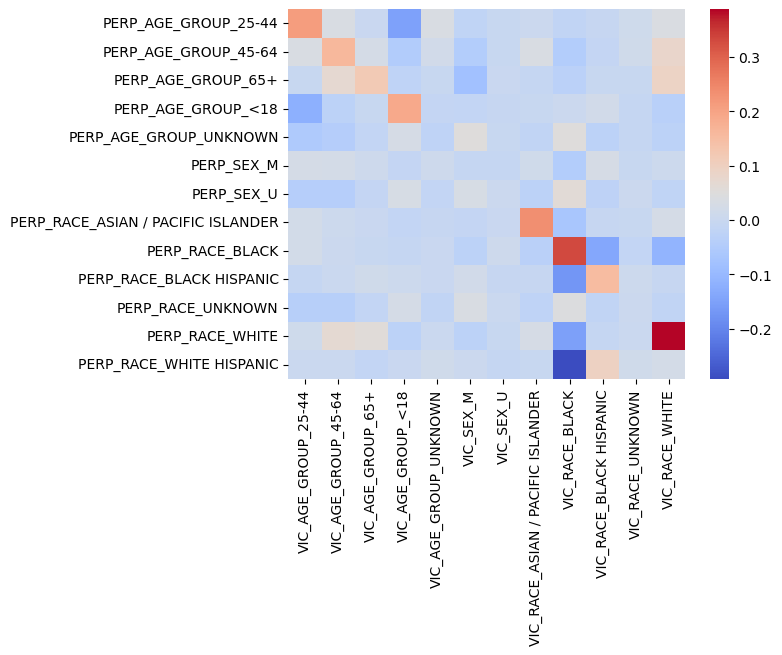

In [33]:
sns.heatmap(d.corr().iloc[-13:,6:18], cmap='coolwarm'); #хитмэп по корреляционной матрице с расами, возрастами и полами

**Вывод:** существует относительно высокая положительная корреляция между расой шутера и расой жертвы (жертвами темнокожих шутеров в основном являются также темнокожие, жертвами белых - белые). Белые испанцы не склонны стрелять в темнокожих. Впоследствии мы проверим гипотезу о независимости рас жертвы и шутера. По корреляционной таблице существует линейная взаимосвязь между районом Бруклин и негроидной расой шутера и жертвы. 

Итак, типичный портрет шутера (по наиболее часто встречающимся признакам): мужчина, чернокожий, от 18 до 24 лет.

Создадим частотную таблицу для рас жертвы и стрелка.

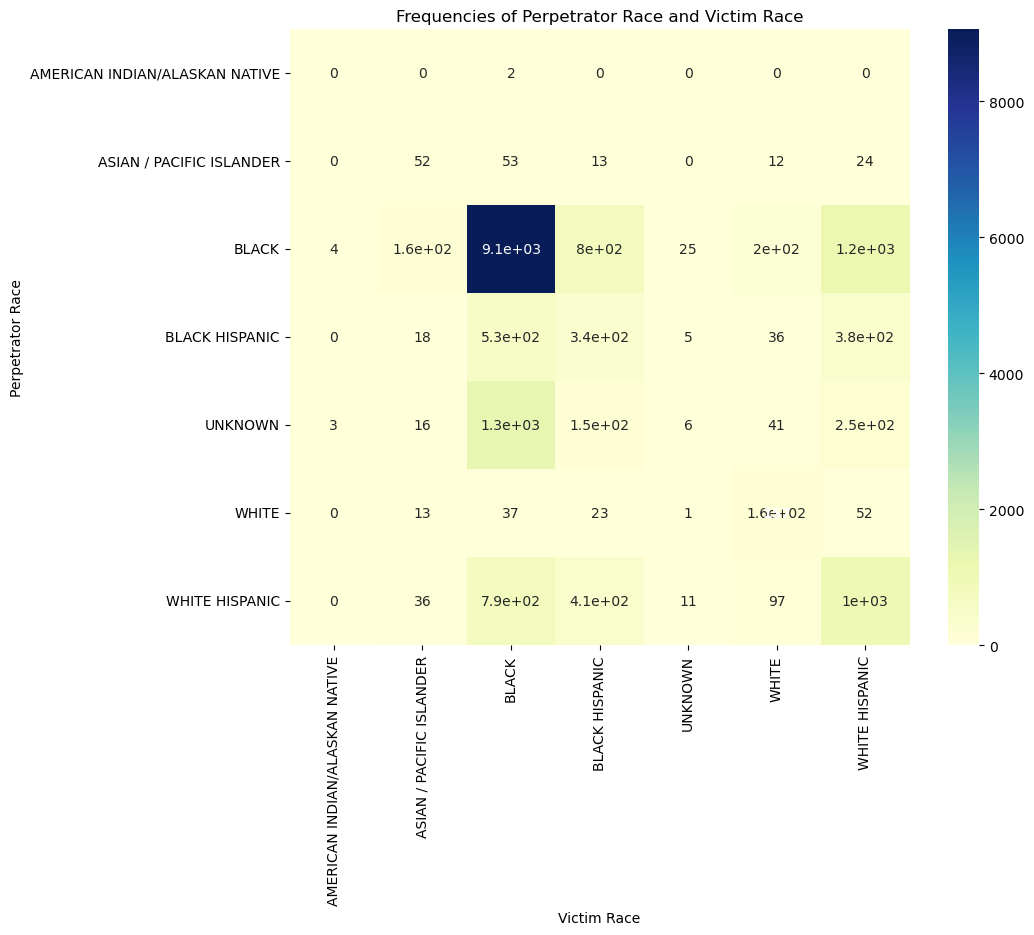

In [34]:
contingency_table = pd.crosstab(df['PERP_RACE'], df['VIC_RACE'])

sorted_table = contingency_table.stack().sort_values(ascending=False).unstack()

highlight_pairs = [('BLACK', 'BlACK'), ('WHITE', 'WHITE')]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_table, annot=True, cmap="YlGnBu")

for i in range(sorted_table.shape[0]):
    for j in range(sorted_table.shape[1]):
        race_pair = (sorted_table.index[i], sorted_table.columns[j])
        if race_pair in highlight_pairs:
            plt.text(j + 0.5, i + 0.5, sorted_table.iloc[i, j],
                     horizontalalignment='center', verticalalignment='center',
                     color='white', fontsize=10, fontweight='bold')

plt.xlabel('Victim Race')
plt.ylabel('Perpetrator Race')
plt.title('Frequencies of Perpetrator Race and Victim Race')
plt.show()

__Вывод:__ наибольшее количество наблюдений (шутингов) имеют расовые характеристики: BLACK and BLACK. Далее по частоте идут пары BLACK - WHITE HISPANIC и UNKNOWN - BLACK. Как категории рас преступника и жертвы соответственно.